In [1]:
#导入pandas库
import pandas as pd

#读取数据集
data = pd.read_csv('user_meal_rating.csv')
data

,UserID,Rating,ReviewTime,Review,MealID
0,A2WOH395IHGS0T,5,1496177056,风味独特，真的不错！,B0040HNZTW
1,A32KHS0VN0N0HB,3,1496177108,有特色，也比较卫生,B006Z48TZS
2,A1YQ4Z5U9NIGP,5,1496177276,家常美味，推荐！,B00CDBTQCW
3,A3E5V5TSTAY3R9,4,1496179256,好吃,B00751IYQ4
4,A1V50CTTDJ73ZM,5,1496180009,不得不赞,B00C0OLT6S
...,...,...,...,...,...
38379,A3UDYY6L2NH3JS,5,1498760000,好吃又划算,B000JO9JHW
38380,A3A4WQL80WOTMH,5,1498760000,家常味道,B002C4Y3DC
38381,A1VF5LN6SHFVFJ,5,1498760000,同事们都很喜欢,B000JO9JHW
38382,AIETV2MBRE5E2,4,1498761601,美味，推荐！,B00FDWGMIE


In [2]:
#查看缺失值
data.isnull().sum()

UserID        0
Rating        0
ReviewTime    0
Review        0
MealID        0
dtype: int64

In [3]:
#查看重复值
data.duplicated().sum()

0

In [4]:
import findspark
findspark.init()
from pyspark import SparkContext,SparkConf
from pyspark.sql import SparkSession

#初始化并创建spark对象
conf = SparkConf().setMaster('local').setAppName('user_meal_data')
spark = SparkSession(SparkContext(conf = conf))

#读取HDFS上的数据，参数header=True为使用第一行作为列的名称
data = spark.read.format('csv').load("/user_meal_data/user_meal_rating.csv",header=True)
data.show()

23/06/21 19:38:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+--------------+------+----------+--------------------+----------+
|        UserID|Rating|ReviewTime|              Review|    MealID|
+--------------+------+----------+--------------------+----------+
|A2WOH395IHGS0T|     5|1496177056|风味独特，真的不错！|B0040HNZTW|
|A32KHS0VN0N0HB|     3|1496177108|  有特色，也比较卫生|B006Z48TZS|
| A1YQ4Z5U9NIGP|     5|1496177276|    家常美味，推荐！|B00CDBTQCW|
|A3E5V5TSTAY3R9|     4|1496179256|                好吃|B00751IYQ4|
|A1V50CTTDJ73ZM|     5|1496180009|            不得不赞|B00C0OLT6S|
|A3GD8QRS50A6OB|     5|1496180056|    每周必点的一道菜|B006WC63X8|
| AK6G2ZYJVQ42D|     5|1496180098|      同事们都很喜欢|B0099JKR6U|
|A2FPYIU94BNC73|     5|1496182040|            性价比高|B0087YNHNI|
|A2WOH395IHGS0T|     5|1496183065|              有惊喜|B002A493NY|
| AM0LNXVIXZKKW|     3|1496184000|            味道一般|B002KGEORM|
|A1VOJC5KLSOWGY|     5|1496184000|太美味了，强烈推荐！|B0045TGRSG|
|A2FPYIU94BNC73|     3|1496184000|            味道很正|B0073J5X58|
| AMXJDVI60YD39|     5|1496184000|太美味了，强烈推荐！|B006Z48TZS|
|A33T3FTA07

In [5]:
#创建临时表user_rating_data
data.createOrReplaceTempView('user_meal_rating')

#Rating字段（用户评分）统计
Rating_stat = spark.sql('select Rating,count(Rating) as num from user_meal_rating group by Rating order by Rating')
Rating_stat.show()

+------+-----+
|Rating|  num|
+------+-----+
|     1| 1782|
|     2| 1960|
|     3| 4475|
|     4| 9142|
|     5|21025|
+------+-----+



In [35]:
#各菜品Rating字段（用户评分）统计
from pyspark.sql.functions import avg
#计算累积评分：使用Spark SQL的聚合函数计算每个菜品的平均评分。
cumulative_ratings = data.groupBy("MealID").agg(round(avg("Rating"),1).alias("CumulativeRating"))
#排序结果：按照累积评分对菜品进行排序。
sorted_cumulative_ratings = cumulative_ratings.orderBy("CumulativeRating", ascending=False)
#显示结果：显示排序后的结果。
sorted_cumulative_ratings.show(10)

+----------+----------------+
|    MealID|CumulativeRating|
+----------+----------------+
|B00CD58R6Y|             5.0|
|B00HUKCIAS|             5.0|
|B00CHU542K|             5.0|
|B00GP74EX6|             5.0|
|B00I9M44E4|             5.0|
|B00AEFSISW|             5.0|
|B00EDG3GQ2|             5.0|
|B00APE00ZG|             5.0|
|B001I8O2MK|             5.0|
|B00627UN0C|             5.0|
+----------+----------------+
only showing top 10 rows



In [8]:
#评论(Review)词频统计
Review_stat = spark.sql('select Review,count(Review) as num from user_meal_rating group by Review order by num desc')
Review_stat.show(10)

+--------------------+-----+
|              Review|  num|
+--------------------+-----+
|太美味了，强烈推荐！|12382|
|          简直太赞了| 6234|
|        非常非常好吃| 3752|
|    很美味，推荐品尝| 3721|
|    此味只应天上有！| 2955|
|            味道很正| 1911|
|        有特色，卫生| 1841|
|  尝过之后，不得不赞| 1257|
|        有特色，好吃|  873|
|              基本OK|  817|
+--------------------+-----+
only showing top 10 rows



In [9]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

spark = SparkSession.builder.master('local').appName('user_meal_data').getOrCreate()
#读取HDFS数据
data = spark.read.format('csv').load("/user_meal_data/user_meal_rating.csv",header=True)
#修改字段结构类型
data = data.select('UserID','MealID','Rating')

data.show(10)

+--------------+----------+------+
|        UserID|    MealID|Rating|
+--------------+----------+------+
|A2WOH395IHGS0T|B0040HNZTW|     5|
|A32KHS0VN0N0HB|B006Z48TZS|     3|
| A1YQ4Z5U9NIGP|B00CDBTQCW|     5|
|A3E5V5TSTAY3R9|B00751IYQ4|     4|
|A1V50CTTDJ73ZM|B00C0OLT6S|     5|
|A3GD8QRS50A6OB|B006WC63X8|     5|
| AK6G2ZYJVQ42D|B0099JKR6U|     5|
|A2FPYIU94BNC73|B0087YNHNI|     5|
|A2WOH395IHGS0T|B002A493NY|     5|
| AM0LNXVIXZKKW|B002KGEORM|     3|
+--------------+----------+------+
only showing top 10 rows



In [10]:
#特征转换
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCols=["MealID","UserID"],outputCols=["MealID_Index","UserID_Index"])
data_index = indexer.fit(data).transform(data)
data_index.show(10)

+--------------+----------+------+------------+------------+
|        UserID|    MealID|Rating|MealID_Index|UserID_Index|
+--------------+----------+------+------------+------------+
|A2WOH395IHGS0T|B0040HNZTW|     5|        57.0|      2749.0|
|A32KHS0VN0N0HB|B006Z48TZS|     3|        11.0|      4327.0|
| A1YQ4Z5U9NIGP|B00CDBTQCW|     5|         4.0|      2472.0|
|A3E5V5TSTAY3R9|B00751IYQ4|     4|       557.0|      2886.0|
|A1V50CTTDJ73ZM|B00C0OLT6S|     5|        28.0|      1161.0|
|A3GD8QRS50A6OB|B006WC63X8|     5|       888.0|       713.0|
| AK6G2ZYJVQ42D|B0099JKR6U|     5|        24.0|      4918.0|
|A2FPYIU94BNC73|B0087YNHNI|     5|       177.0|      1224.0|
|A2WOH395IHGS0T|B002A493NY|     5|       240.0|      2749.0|
| AM0LNXVIXZKKW|B002KGEORM|     3|       121.0|      4948.0|
+--------------+----------+------+------------+------------+
only showing top 10 rows



In [12]:
from pyspark.ml.recommendation import ALS
#字段类型转换，因为ALS模型只支持int或float
data_als = data_index.selectExpr(
    "cast(MealID_Index as int) MealID_Index",
    "cast(UserID_Index as int) UserID_Index",
    "cast(Rating as float) Rating"
)

#拆分数据集
training,test = data_als.randomSplit([0.8,0.2])

#构建ALS模型，将冷启动策略设置为“下降”（coldStartStrategy="drop"),以确保我们不会获得NaN评估指标
als = ALS(maxIter=5, regParam=0.01,userCol='UserID_Index',\
          itemCol='MealID_Index',ratingCol='Rating',coldStartStrategy="drop")

#训练模型
model = als.fit(training)

In [13]:
from pyspark.ml.evaluation import RegressionEvaluator
# 评估模型
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName='rmse',labelCol='Rating',predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print('均方根误差='+str(rmse))

均方根误差=5.814012636953366


In [24]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

#为每个用户生成十大菜品推荐
userRecs = model.recommendForAllUsers(10)
#结果转换
flatUserRecs = userRecs.rdd.flatMapValues(lambda p: p)
#转换后的结果放在DataFrame中
userRecs_res = spark.createDataFrame(flatUserRecs)
#字段名称重命名
userRecs_res = userRecs_res.selectExpr("cast(_1 as int) UserID_Index",
                                       "cast(_2 as String) recommed")
# 将生成的推荐数据保存到本地
userRecs_res.toPandas().to_csv('user10_recommend.csv',index=False,header=None)
userRecs_res.show()

+------------+--------------------+
|UserID_Index|            recommed|
+------------+--------------------+
|        1580|{537, 18.91238212...|
|        1580|{527, 17.69466209...|
|        1580|{207, 16.76772880...|
|        1580|{269, 16.72339248...|
|        1580|{272, 16.44668388...|
|        1580|{615, 16.29764366...|
|        1580|{917, 15.80331039...|
|        1580|{794, 15.69475650...|
|        1580|{1458, 15.4965381...|
|        1580|{660, 15.44904994...|
|        4900|{1221, 20.7506217...|
|        4900|{309, 19.55834197...|
|        4900|{1411, 17.3811035...|
|        4900|{601, 16.44636917...|
|        4900|{276, 16.39932250...|
|        4900|{702, 15.91857624...|
|        4900|{860, 15.85458564...|
|        4900|{301, 15.67586898...|
|        4900|{799, 15.66829776...|
|        4900|{580, 15.61127281...|
+------------+--------------------+
only showing top 20 rows



In [18]:
# 为每个菜品生成十大用户推荐
mealRecs = model.recommendForAllItems(10)
# mealRecs.show()
# 结果转换
flatMealRecs = mealRecs.rdd.flatMapValues(lambda p : p)
mealRecs_res = spark.createDataFrame(flatMealRecs)
# 字段名称重命名
mealRecs_res1 = mealRecs_res.selectExpr('cast(_1 as int) MealID_index','cast(_2 as String) recommend')
# 将生成的推荐数据保存到本地
mealRecs_res1.toPandas().to_csv('meal10_recommend.csv',index=False,header=None)
mealRecs_res1.show()

+------------+--------------------+
|MealID_index|           recommend|
+------------+--------------------+
|        1580|{220, 22.22053337...|
|        1580|{270, 19.96629142...|
|        1580|{1280, 18.4714012...|
|        1580|{3229, 18.1163330...|
|        1580|{288, 17.92160606...|
|        1580|{957, 17.63733291...|
|        1580|{661, 15.98784732...|
|        1580|{4096, 15.0822772...|
|        1580|{345, 15.07214260...|
|        1580|{3800, 14.9995050...|
|         471|{599, 33.70029449...|
|         471|{147, 30.67490005...|
|         471|{175, 27.57756805...|
|         471|{5071, 27.4481430...|
|         471|{83, 26.758817672...|
|         471|{464, 26.51372528...|
|         471|{545, 26.41010093...|
|         471|{257, 26.14504241...|
|         471|{830, 26.03369140...|
|         471|{3800, 23.9905776...|
+------------+--------------------+
only showing top 20 rows



In [19]:
# 生成基于用户推荐
users = userRecs_res.select(als.getUserCol()).distinct().limit(10)
userRecs1 = model.recommendForUserSubset(users, 10)
userRecs1.show()
# 生成基于菜品推荐
items = mealRecs_res1.select(als.getItemCol()).distinct().limit(10)
itemRecs1 = model.recommendForItemSubset(items, 10)
itemRecs1.show()

+------------+--------------------+
|UserID_Index|     recommendations|
+------------+--------------------+
|        1580|[{537, 18.912382}...|
|        4900|[{1221, 20.750622...|
|         471|[{309, 42.54187},...|
|        1591|[{779, 16.316833}...|
|        4101|[{1192, 6.756077}...|
|        1342|[{581, 20.37288},...|
|        2122|[{406, 15.569576}...|
|        2142|[{1124, 9.330818}...|
|         463|[{778, 12.198782}...|
|         833|[{819, 45.791084}...|
+------------+--------------------+



+------------+--------------------+
|MealID_Index|     recommendations|
+------------+--------------------+
|        1580|[{220, 22.220533}...|
|         471|[{599, 33.700294}...|
|        1591|[{628, 24.197042}...|
|        1342|[{334, 18.154333}...|
|         463|[{618, 40.37677},...|
|         833|[{269, 43.63918},...|
|        1645|[{1306, 37.145927...|
|         496|[{628, 53.35273},...|
|         148|[{5071, 31.590399...|
|        1088|[{378, 35.716015}...|
+------------+--------------------+



In [26]:
# 为指定的用户生成十大推荐
user_df = spark.createDataFrame([(2040,)],['UserID_Index'])
user_recs = model.recommendForUserSubset(user_df,10)
user_recs.show(truncate=False)

+------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|UserID_Index|recommendations                                                                                                                                                                       |
+------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|2040        |[{582, 16.823814}, {615, 15.252868}, {987, 14.551615}, {527, 13.795489}, {723, 13.7166395}, {381, 12.865194}, {738, 12.762522}, {266, 12.2411175}, {346, 12.165103}, {185, 12.083395}]|
+------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+



In [27]:
# 为指定的菜品生成十大用户推荐
item_df = spark.createDataFrame([(270,)],['MealID_Index'])
item_recs = model.recommendForItemSubset(item_df,10)
item_recs.show(truncate=False)

+------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|MealID_Index|recommendations                                                                                                                                                                       |
+------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|270         |[{2244, 52.18582}, {236, 48.309452}, {150, 44.473682}, {185, 40.205135}, {1306, 40.040623}, {1572, 37.858982}, {633, 35.818012}, {258, 35.33159}, {315, 34.976032}, {1998, 33.407257}]|
+------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+



In [28]:
# 生成用户对菜品的十大最佳匹配度
res_users = userRecs.selectExpr('UserID_Index','explode(recommendations) as mr')
res_users1 = res_users.selectExpr('UserID_Index','mr.MealID_Index','mr.Rating')
res_users1.printSchema()
res_users1.show()

root
 |-- UserID_Index: integer (nullable = false)
 |-- MealID_Index: integer (nullable = true)
 |-- Rating: float (nullable = true)



+------------+------------+----------+
|UserID_Index|MealID_Index|    Rating|
+------------+------------+----------+
|        1580|         537| 18.912382|
|        1580|         527| 17.694662|
|        1580|         207| 16.767729|
|        1580|         269| 16.723392|
|        1580|         272| 16.446684|
|        1580|         615| 16.297644|
|        1580|         917|  15.80331|
|        1580|         794|15.6947565|
|        1580|        1458| 15.496538|
|        1580|         660|  15.44905|
|        4900|        1221| 20.750622|
|        4900|         309| 19.558342|
|        4900|        1411| 17.381104|
|        4900|         601|  16.44637|
|        4900|         276| 16.399323|
|        4900|         702| 15.918576|
|        4900|         860| 15.854586|
|        4900|         301| 15.675869|
|        4900|         799| 15.668298|
|        4900|         580| 15.611273|
+------------+------------+----------+
only showing top 20 rows



In [29]:
# 生成菜品对用户的十大最佳匹配度
res_items = mealRecs.selectExpr('MealID_Index','explode(recommendations) as ur')
res_items1 = res_items.selectExpr('MealID_Index','ur.UserID_Index','ur.Rating')
res_items1.printSchema()
res_items1.show()

root
 |-- MealID_Index: integer (nullable = false)
 |-- UserID_Index: integer (nullable = true)
 |-- Rating: float (nullable = true)



+------------+------------+---------+
|MealID_Index|UserID_Index|   Rating|
+------------+------------+---------+
|        1580|         220|22.220533|
|        1580|         270|19.966291|
|        1580|        1280|18.471401|
|        1580|        3229|18.116333|
|        1580|         288|17.921606|
|        1580|         957|17.637333|
|        1580|         661|15.987847|
|        1580|        4096|15.082277|
|        1580|         345|15.072143|
|        1580|        3800|14.999505|
|         471|         599|33.700294|
|         471|         147|  30.6749|
|         471|         175|27.577568|
|         471|        5071|27.448143|
|         471|          83|26.758818|
|         471|         464|26.513725|
|         471|         545|  26.4101|
|         471|         257|26.145042|
|         471|         830|26.033691|
|         471|        3800|23.990578|
+------------+------------+---------+
only showing top 20 rows



In [45]:
# 将推荐结果存放到数据仓库
prop = {}
prop['user'] = 'root'
prop['password'] = 'a'
prop['driver'] = 'com.mysql.cj.jdbc.Driver'

#生成菜品对用户的十大最佳匹配度写入数据库
data_index.write.jdbc('jdbc:mysql://localhost:3306/spark','All_data','overwrite',prop)
#将用户评分统计数据写入数据库
Rating_stat.write.jdbc('jdbc:mysql://localhost:3306/spark','Rating_count','overwrite',prop)
#将菜品平均分统计数据写入数据库
sorted_cumulative_ratings.write.jdbc('jdbc:mysql://localhost:3306/spark','avg_Rating','overwrite',prop)
#用户对菜品的十大最佳匹配度写入数据库
res_users1.write.jdbc('jdbc:mysql://localhost:3306/spark','user_meal','overwrite',prop)
#生成菜品对用户的十大最佳匹配度写入数据库
res_items1.write.jdbc('jdbc:mysql://localhost:3306/spark','meal_user','overwrite',prop)

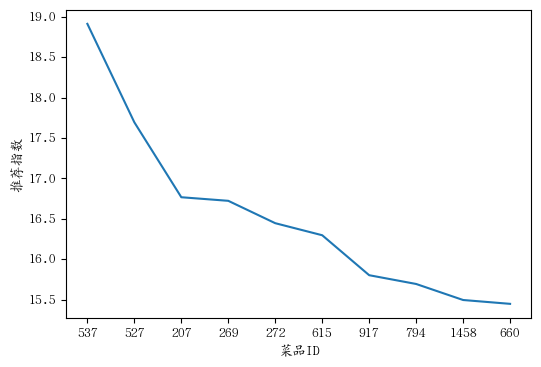

In [25]:
import matplotlib.pyplot as plt
user_plt = userRecs1.filter(userRecs1['UserID_Index'] == 1580).collect()
user_plt = spark.createDataFrame(user_plt[0][1])
MealID_Index = user_plt.select('MealID_Index').rdd.flatMap(lambda x:x).collect()
Rating = user_plt.select('Rating').rdd.flatMap(lambda x:x).collect()
MealID_Index = list(map(str,MealID_Index))
plt.rcParams['font.sans-serif'] = ['AR PL UKai CN']
plt.figure(figsize=(6,4),dpi=100)
plt.xlabel('菜品ID')
plt.ylabel('推荐指数')
plt.plot(MealID_Index,Rating)
plt.show()

In [42]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

spark = SparkSession.builder.master('local').appName('user_meal_data').getOrCreate()
#读取HDFS数据
data = spark.read.format('csv').load("/user_meal_data/user_meal_rating.csv",header=True)
#修改字段结构类型
data.show(10)

+--------------+------+----------+--------------------+----------+
|        UserID|Rating|ReviewTime|              Review|    MealID|
+--------------+------+----------+--------------------+----------+
|A2WOH395IHGS0T|     5|1496177056|风味独特，真的不错！|B0040HNZTW|
|A32KHS0VN0N0HB|     3|1496177108|  有特色，也比较卫生|B006Z48TZS|
| A1YQ4Z5U9NIGP|     5|1496177276|    家常美味，推荐！|B00CDBTQCW|
|A3E5V5TSTAY3R9|     4|1496179256|                好吃|B00751IYQ4|
|A1V50CTTDJ73ZM|     5|1496180009|            不得不赞|B00C0OLT6S|
|A3GD8QRS50A6OB|     5|1496180056|    每周必点的一道菜|B006WC63X8|
| AK6G2ZYJVQ42D|     5|1496180098|      同事们都很喜欢|B0099JKR6U|
|A2FPYIU94BNC73|     5|1496182040|            性价比高|B0087YNHNI|
|A2WOH395IHGS0T|     5|1496183065|              有惊喜|B002A493NY|
| AM0LNXVIXZKKW|     3|1496184000|            味道一般|B002KGEORM|
+--------------+------+----------+--------------------+----------+
only showing top 10 rows



In [43]:
#特征转换
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCols=["MealID","UserID"],outputCols=["MealID_Index","UserID_Index"])
data_index = indexer.fit(data).transform(data)
data_index.show(10)

+--------------+------+----------+--------------------+----------+------------+------------+
|        UserID|Rating|ReviewTime|              Review|    MealID|MealID_Index|UserID_Index|
+--------------+------+----------+--------------------+----------+------------+------------+
|A2WOH395IHGS0T|     5|1496177056|风味独特，真的不错！|B0040HNZTW|        57.0|      2749.0|
|A32KHS0VN0N0HB|     3|1496177108|  有特色，也比较卫生|B006Z48TZS|        11.0|      4327.0|
| A1YQ4Z5U9NIGP|     5|1496177276|    家常美味，推荐！|B00CDBTQCW|         4.0|      2472.0|
|A3E5V5TSTAY3R9|     4|1496179256|                好吃|B00751IYQ4|       557.0|      2886.0|
|A1V50CTTDJ73ZM|     5|1496180009|            不得不赞|B00C0OLT6S|        28.0|      1161.0|
|A3GD8QRS50A6OB|     5|1496180056|    每周必点的一道菜|B006WC63X8|       888.0|       713.0|
| AK6G2ZYJVQ42D|     5|1496180098|      同事们都很喜欢|B0099JKR6U|        24.0|      4918.0|
|A2FPYIU94BNC73|     5|1496182040|            性价比高|B0087YNHNI|       177.0|      1224.0|
|A2WOH395IHGS0T|     5|149618

In [48]:
# 分析统计各菜品累积评分
meal_sum = spark.sql("SELECT MealID, SUM(Rating) AS sum_rating FROM All_data GROUP BY mealID ORDER BY sum_rating DESC")
meal_sum.show(20)

AnalysisException: Table or view not found: All_data; line 1 pos 46;
'Sort ['sum_rating DESC NULLS LAST], true
+- 'Aggregate ['mealID], ['MealID, 'SUM('Rating) AS sum_rating#22774]
   +- 'UnresolvedRelation [All_data], [], false


In [49]:
import jieba
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyecharts import options as opts
from pyecharts.charts import WordCloud

# 对评价进行分词
cut_text_udf = udf(lambda x: " ".join(jieba.cut(x)), StringType())
review_cut = review.select("Review").withColumn("cut_text", cut_text_udf("Review"))

# 统计各个词的出现次数
word_count = review_cut.rdd.flatMap(lambda x: x[1].split()).map(lambda x: (x, 1)).reduceByKey(lambda a, b: a + b).collect()

# 绘制词云图
wordcloud = (
    WordCloud()
    .add("", word_count, word_size_range=[20, 100])
    .set_global_opts(title_opts=opts.TitleOpts(title="评价词云图"))
)

# 输出词云图
wordcloud.render("/home/hadoop/jupyternotebook/review_wordcloud.html")

ModuleNotFoundError: No module named 'jieba'

In [50]:
pip install jieba

Defaulting to user installation because normal site-packages is not writeable
     ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.4/19.2 MB 25.9 kB/s eta 0:12:09^C
     ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.4/19.2 MB 25.9 kB/s eta 0:12:09
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.
